In [1]:
import os
import re
import gc
import random 
import math
import json
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
warnings.filterwarnings("ignore")

In [2]:
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, roc_auc_score


from imblearn.over_sampling import SMOTE, ADASYN

import plotly.express as px
import plotly.graph_objects as go

import umap
from sentence_transformers import SentenceTransformer

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

def basic_clean(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r"[^a-z0-9.,;:!?()\/'\"\s-]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 120
sns.set(style="whitegrid")

def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig = px.imshow(cm, x=labels, y=labels, text_auto=True, aspect="auto", color_continuous_scale="Blues")
    fig.update_layout(title=title, xaxis_title="Predicted", yaxis_title="True", width=900, height=900)
    fig.show()
def plot_roc_curves(y_true_bin, y_proba, class_names):
    n_classes = y_true_bin.shape[1]
    fig = go.Figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"{class_names[i]} (AUC={auc:.3f})"))
    fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Chance', line=dict(dash='dash')))
    fig.update_layout(title="One-vs-Rest ROC Curves", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", width=900, height=600)
    fig.show()

def plot_pr_curves(y_true_bin, y_proba, class_names):
    n_classes = y_true_bin.shape[1]
    fig = go.Figure()
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
        fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name=f"{class_names[i]} (AP={ap:.3f})"))
    fig.update_layout(title="One-vs-Rest Precision-Recall Curves", xaxis_title="Recall", yaxis_title="Precision", width=900, height=600)
    fig.show()

2025-09-06 17:39:17.474636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757180357.498889     116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757180357.506282     116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DATA_PATH = "/kaggle/input/medicaltranscriptions/mtsamples.csv"  

df = pd.read_csv(DATA_PATH)
print("Columns found:", df.columns.tolist())
df = df.rename(columns={c: c.strip() for c in df.columns})
assert {'transcription','medical_specialty'}.issubset(df.columns), "Expected columns not found."

# Basic clean (safe regex – fixes your earlier 'bad character range' crash)
def basic_clean(text: str) -> str:
    text = str(text).lower()
    text = text.encode('ascii', 'ignore').decode('ascii')   # strip accents
    # Keep letters, digits, punctuation we care about; escape the hyphen
    text = re.sub(r"[^a-z0-9\.\,\;\:\!\?\/'\"\- \n\t]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text'] = df['transcription'].astype(str)
df['text_clean'] = df['text'].apply(basic_clean)

# Drop empties/dupes on (text_clean + label)
df = df.dropna(subset=['text_clean','medical_specialty'])
df = df.drop_duplicates(subset=['text_clean','medical_specialty']).reset_index(drop=True)
print(df.shape)
df.head(2)

Columns found: ['Unnamed: 0', 'description', 'medical_specialty', 'sample_name', 'transcription', 'keywords']
(4972, 8)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,text,text_clean
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...","SUBJECTIVE:, This 23-year-old white female pr...","subjective:, this 23-year-old white female pre..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","PAST MEDICAL HISTORY:, He has difficulty climb...","past medical history:, he has difficulty climb..."


In [4]:
print("Head:"); display(df.head())
print("Info:"); print(df.info())
print("Nulls:"); print(df.isna().sum())

Head:


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,text,text_clean
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...","SUBJECTIVE:, This 23-year-old white female pr...","subjective:, this 23-year-old white female pre..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...","PAST MEDICAL HISTORY:, He has difficulty climb...","past medical history:, he has difficulty climb..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...","HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","history of present illness: , i have seen abc ..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","2-D M-MODE: , ,1. Left atrial enlargement wit...","2-d m-mode: , ,1. left atrial enlargement with..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",1. The left ventricular cavity size and wall ...,1. the left ventricular cavity size and wall t...


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4972 entries, 0 to 4971
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4972 non-null   int64 
 1   description        4972 non-null   object
 2   medical_specialty  4972 non-null   object
 3   sample_name        4972 non-null   object
 4   transcription      4964 non-null   object
 5   keywords           3904 non-null   object
 6   text               4972 non-null   object
 7   text_clean         4972 non-null   object
dtypes: int64(1), object(7)
memory usage: 310.9+ KB
None
Nulls:
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription           8
keywords             1068
text                    0
text_clean              0
dtype: int64


In [5]:
EXPECTED_TEXT_COLS = ['transcription', 'description', 'medical_specialty', 'sample_name', 'keywords']
present = [c for c in EXPECTED_TEXT_COLS if c in df.columns]
print("Columns found:", present)

TEXT_COL = 'transcription' if 'transcription' in df.columns else present[0]
TARGET_COL = 'medical_specialty' if 'medical_specialty' in df.columns else None
assert TARGET_COL is not None, "medical_specialty column not found."

df['text'] = df[TEXT_COL].astype(str)
df['text_clean'] = df['text'].apply(basic_clean)
df = df.dropna(subset=[TARGET_COL, 'text_clean'])
df = df.drop_duplicates(subset=['text_clean', TARGET_COL]).reset_index(drop=True)
print(df.head())
print(f"Using TEXT_COL='{TEXT_COL}', TARGET_COL='{TARGET_COL}'. Cleaned rows:", len(df))
label_counts = df[TARGET_COL].value_counts().sort_values(ascending=False)
display(label_counts.to_frame(name='count'))

Columns found: ['transcription', 'description', 'medical_specialty', 'sample_name', 'keywords']
   Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                

,count
medical_specialty,
Surgery,1089
Consult - History and Phy.,516
Cardiovascular / Pulmonary,372
Orthopedic,355
Radiology,273
General Medicine,259
Gastroenterology,225
Neurology,223
SOAP / Chart / Progress Notes,166


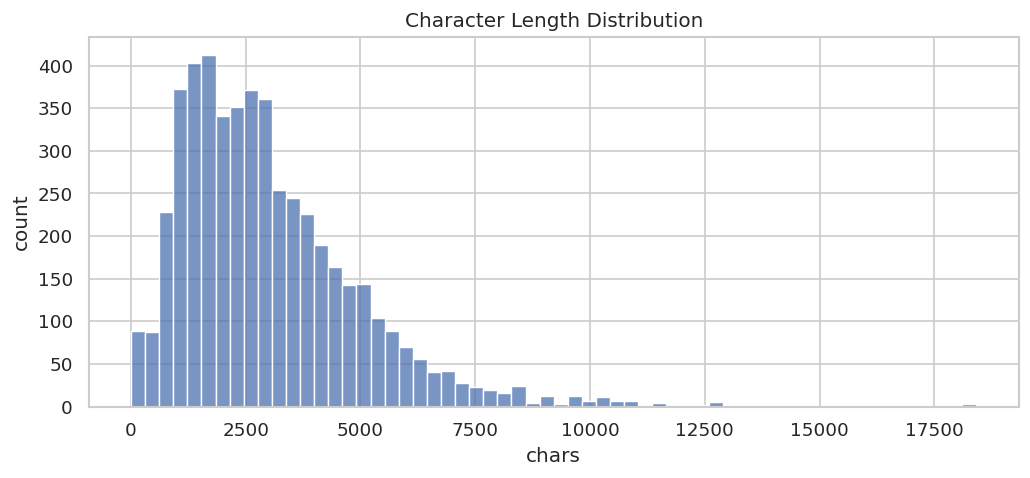

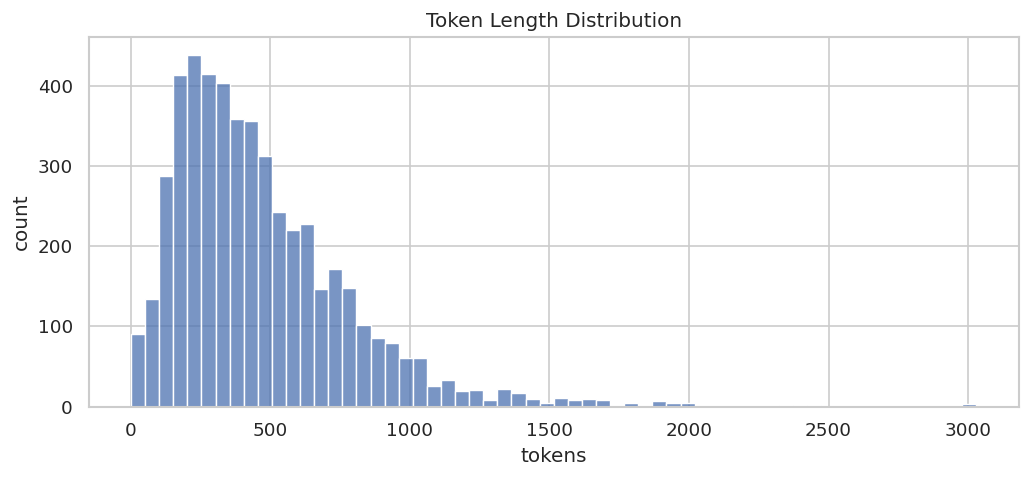

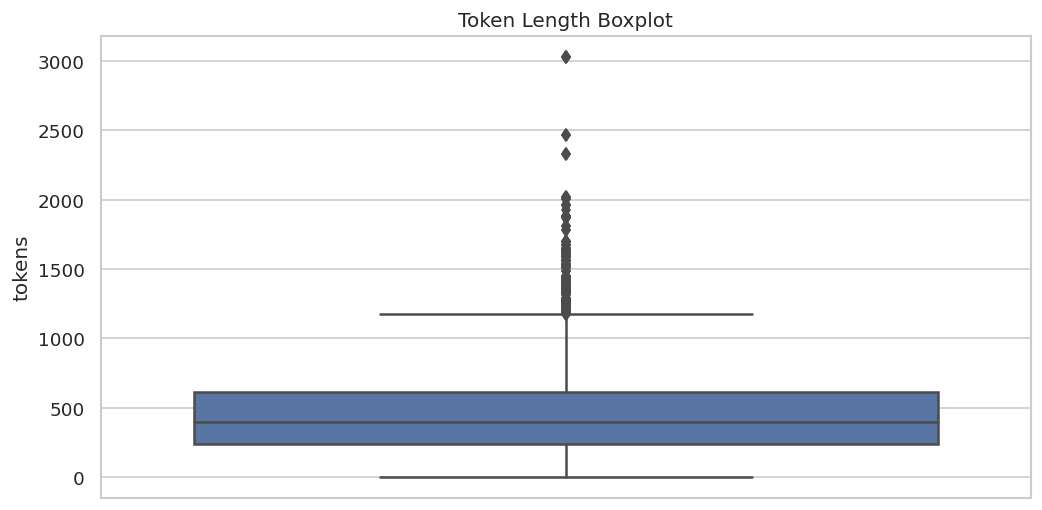

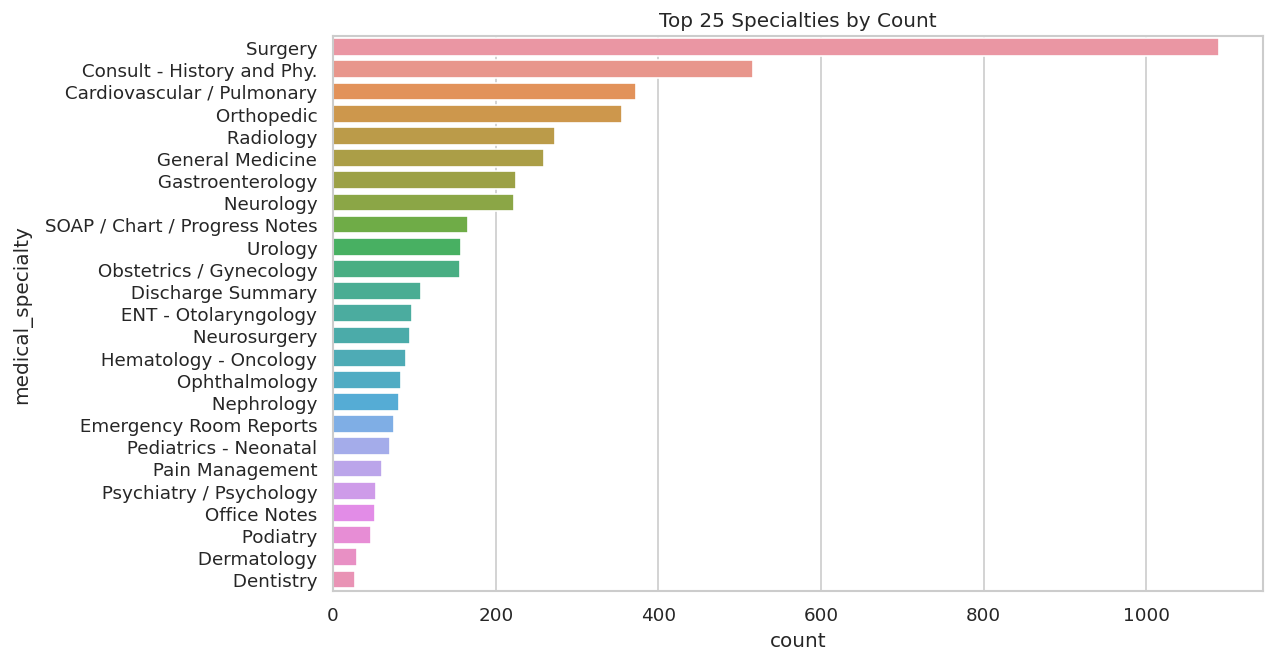

Classes: 40


count      40.000000
mean      124.300000
std       195.826611
min         6.000000
25%        18.750000
50%        56.500000
75%       156.250000
max      1089.000000
Name: count, dtype: float64

In [6]:
df['char_len']  = df['text_clean'].str.len()
df['token_len'] = df['text_clean'].str.split().apply(len)

plt.figure(figsize=(10,4))
sns.histplot(df['char_len'], bins=60)
plt.title('Character Length Distribution'); plt.xlabel('chars'); plt.ylabel('count'); plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['token_len'], bins=60)
plt.title('Token Length Distribution'); plt.xlabel('tokens'); plt.ylabel('count'); plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(y=df['token_len'])
plt.title('Token Length Boxplot'); plt.ylabel('tokens'); plt.show()

# Class counts
cls_counts = df['medical_specialty'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=cls_counts.values[:25], y=cls_counts.index[:25])
plt.title('Top 25 Specialties by Count'); plt.xlabel('count'); plt.ylabel('medical_specialty'); plt.show()

print("Classes:", len(cls_counts))
cls_counts.describe()

In [7]:
df['char_len'] = df['text_clean'].str.len()
df['token_len'] = df['text_clean'].str.split().apply(len)

fig = px.histogram(df, x='char_len', nbins=60, title='Character Length Distribution'); fig.show()
fig = px.histogram(df, x='token_len', nbins=60, title='Token Length Distribution'); fig.show()
fig = px.box(df, y='token_len', points='suspectedoutliers', title='Token Length Boxplot'); fig.show()

print(df[['char_len', 'token_len']].describe())

           char_len    token_len
count   4972.000000  4972.000000
mean    3014.427595   465.371279
std     1976.194613   316.883266
min        3.000000     1.000000
25%     1588.000000   241.000000
50%     2636.000000   398.000000
75%     3973.000000   616.000000
max    18416.000000  3030.000000


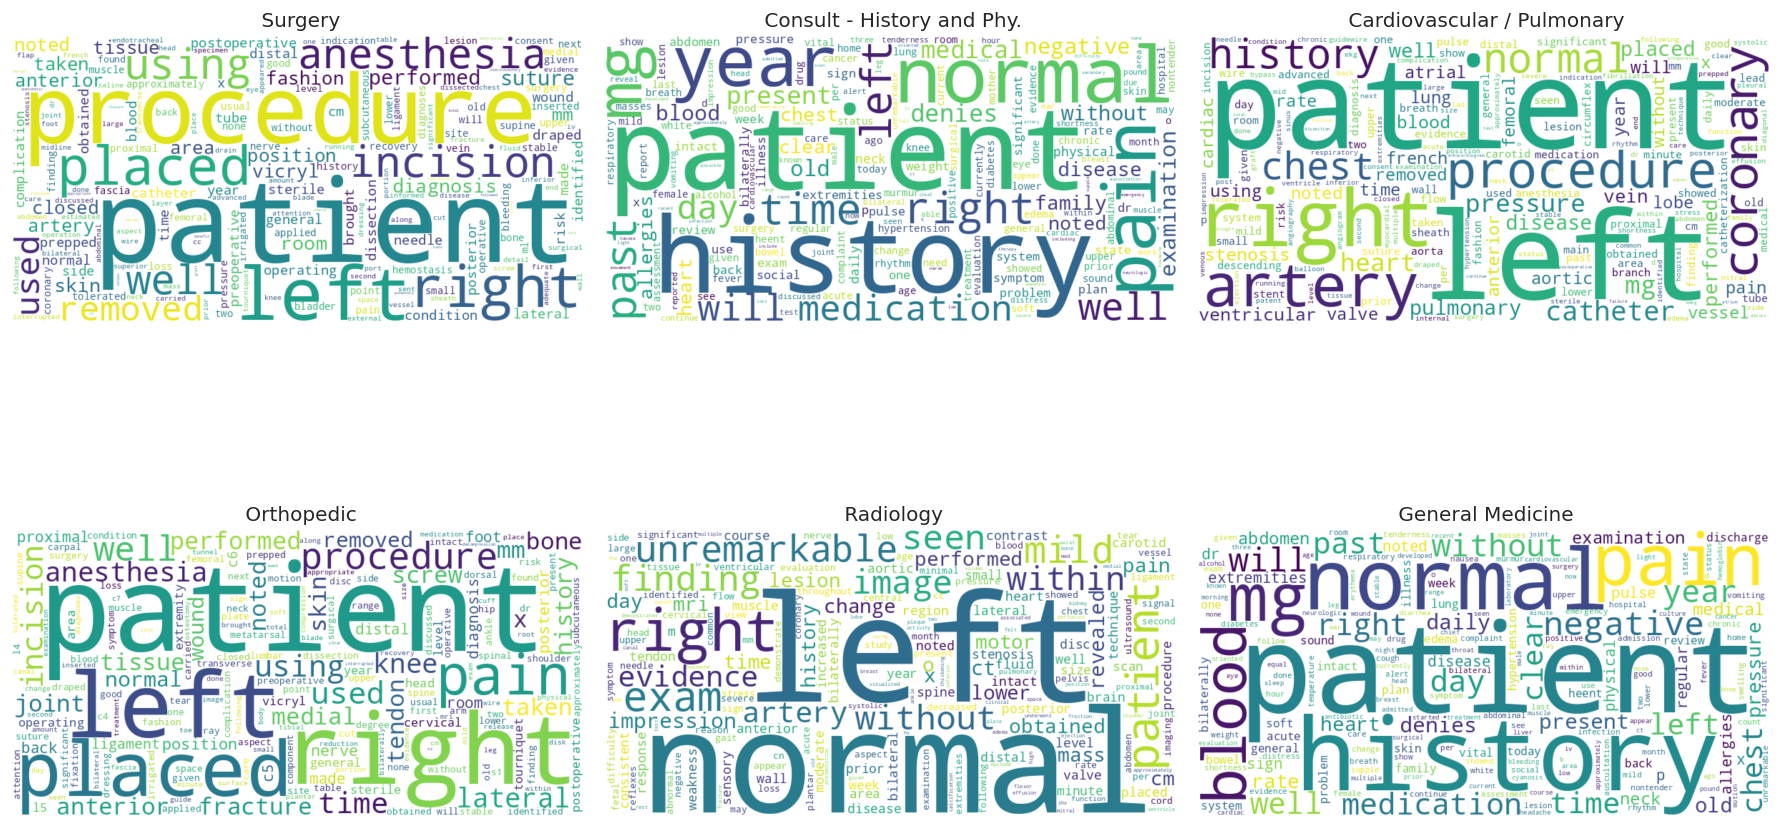

In [8]:
import math
top_k_classes = 6  # @param {type:"slider", min:3, max:12, step:1}
top_classes = df[TARGET_COL].value_counts().index[:top_k_classes]

fig, axes = plt.subplots(math.ceil(top_k_classes/3), 3, figsize=(15, 5*math.ceil(top_k_classes/3)))
axes = axes.ravel()

for i, cls in enumerate(top_classes):
    text = " ".join(df.loc[df[TARGET_COL]==cls, 'text_clean'].values)
    wc = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(text)
    axes[i].imshow(wc, interpolation='bilinear'); axes[i].set_title(cls); axes[i].axis("off")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout(); plt.show()

In [9]:
def top_ngrams(texts, ngram_range=(1,1), top=25, stop_words='english'):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(texts)
    sums = np.asarray(X.sum(axis=0)).ravel()
    freqs = list(zip(vec.get_feature_names_out(), sums))
    freqs.sort(key=lambda x: x[1], reverse=True)
    return freqs[:top]

uni = top_ngrams(df['text_clean'], (1,1), 25)
bi  = top_ngrams(df['text_clean'], (2,2), 25)
tri = top_ngrams(df['text_clean'], (3,3), 25)

display(pd.DataFrame(uni, columns=['unigram','count']))
display(pd.DataFrame(bi,  columns=['bigram','count']))
display(pd.DataFrame(tri, columns=['trigram','count']))

fig = px.bar(pd.DataFrame(uni, columns=['unigram','count']), x='unigram', y='count', title='Top Unigrams'); fig.show()
fig = px.bar(pd.DataFrame(bi, columns=['bigram','count']), x='bigram', y='count', title='Top Bigrams'); fig.show()
fig = px.bar(pd.DataFrame(tri, columns=['trigram','count']), x='trigram', y='count', title='Top Trigrams'); fig.show()

,unigram,count
0,patient,24140
1,right,11587
2,left,11258
3,history,9509
4,normal,7526
5,procedure,7462
6,placed,7028
7,pain,5976
8,noted,4348
9,time,4287


,bigram,count
0,year old,2943
1,operating room,1594
2,prepped draped,1498
3,procedure patient,1463
4,blood pressure,1265
5,medical history,1223
6,preoperative diagnosis,1176
7,physical examination,1156
8,tolerated procedure,1132
9,vital signs,1121


,trigram,count
0,past medical history,1063
1,history present illness,1042
2,patient tolerated procedure,930
3,prepped draped usual,801
4,estimated blood loss,754
5,year old female,665
6,taken operating room,588
7,present illness patient,542
8,draped usual sterile,497
9,patient taken operating,485


In [10]:
from sentence_transformers import SentenceTransformer

# Directly load ClinicalBERT adapted for sentence embeddings
encoder = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')

# Embedding Visualization
sample_size = 2000  # @param {type:"slider", min:500, max:5000, step:100}
df_vis = df.sample(min(sample_size, len(df)), random_state=RANDOM_STATE).copy()

# encoder = SentenceTransformer('all-MiniLM-L6-v2')
embs = encoder.encode(df_vis['text_clean'].tolist(), show_progress_bar=True)

reducer = umap.UMAP(random_state=RANDOM_STATE)
Z = reducer.fit_transform(embs)

df_vis['x'] = Z[:,0]; df_vis['y'] = Z[:,1]
fig = px.scatter(df_vis, x='x', y='y', color=TARGET_COL, title="UMAP of Sentence Embeddings (sampled)",
                 width=900, height=700); fig.show()

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

RANDOM_STATE = 42  # For reproducibility

# --- Step 1: Get the original, un-merged class names from the DataFrame ---
# The `sorted()` function ensures a consistent, alphabetical order for the labels.
class_names = sorted(df['medical_specialty'].unique().tolist())
num_labels = len(class_names)
print(f"Using the original {num_labels} medical specialties as classes.")


# --- Step 2: Create the label-to-integer mapping dictionaries ---
# These are essential for converting string labels to numbers for the model.
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for i, name in enumerate(class_names)}


# --- Step 3: Apply the mapping to the DataFrame to create the 'label' column ---
# This uses the original 'medical_specialty' column, not a merged/clustered one.
df['label'] = df['medical_specialty'].map(label2id)


# --- Step 4: Prepare data for splitting ---
# We use the pre-cleaned text column and the newly created numeric 'label' column.
# Ensure 'text_clean' is the correct name of your preprocessed text column.
X = df['text_clean'].values
y = df['label'].values

# --- Step 5: Split the data into training and validation sets ---
# `stratify=y` is now even more crucial to handle the severe class imbalance
# of the original 40 classes, ensuring both sets are representative.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


# --- Final Verification ---
print(f"\nTrain/Val sizes: {len(X_train)} / {len(X_val)}")
print(f"Unique classes in training set (first 20): {np.unique(y_train)[:20]}")
print(f"Number of unique classes: {len(np.unique(y_train))}")

# Verify the final class names list matches the original list
final_class_list_check = [id2label[i] for i in range(num_labels)]
print("\nFinal class list (first 10):", final_class_list_check[:10])

# The variables X_train, y_train, X_val, y_val, id2label, label2id, etc.,
# are now ready for the rest of your notebook.

Using the original 40 medical specialties as classes.

Train/Val sizes: 3977 / 995
Unique classes in training set (first 20): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Number of unique classes: 40

Final class list (first 10): [' Allergy / Immunology', ' Autopsy', ' Bariatrics', ' Cardiovascular / Pulmonary', ' Chiropractic', ' Consult - History and Phy.', ' Cosmetic / Plastic Surgery', ' Dentistry', ' Dermatology', ' Diets and Nutritions']


In [13]:
# GPU check
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [14]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding

model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df   = pd.DataFrame({'text': X_val,   'label': y_val})

hf_ds = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False)
})

MAX_LEN = 384  # you can try 256 or 512 too

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN
    )

tokenized = hf_ds.map(tokenize_fn, batched=True, remove_columns=['text'])
data_collator = DataCollatorWithPadding(tokenizer)
tokenized

Map:   0%|          | 0/3977 [00:00<?, ? examples/s]

Map:   0%|          | 0/995 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3977
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 995
    })
})

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(class_names)),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("class_weights (first 10):", class_weights[:10])

# Optional: Class-balanced sampler (often helps with severe skew)
# You can turn this ON by passing `train_sampler=train_sampler` into Trainer below.
from torch.utils.data import WeightedRandomSampler

train_labels_series = train_df['label'].value_counts()
label_to_count = train_labels_series.to_dict()
weights_per_label = {lbl: 1.0/count for lbl, count in label_to_count.items()}
sample_weights = [weights_per_label[lbl] for lbl in train_df['label']]
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

class_weights (first 10): [16.57083333 16.57083333  7.10178571  0.33364094  9.03863636  0.2407385
  4.51931818  4.51931818  4.32282609 12.428125  ]


In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape)

use_adasyn = False  # @param {type:"boolean"}
over_sampler = ADASYN(random_state=RANDOM_STATE, n_neighbors=3) if use_adasyn else SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
X_train_bal, y_train_bal = over_sampler.fit_resample(X_train_tfidf, y_train)
print("After oversampling:", X_train_bal.shape)

TF-IDF shapes: (3977, 118885) (995, 118885)
After oversampling: (34840, 118885)


In [17]:
# LinearSVC
svm = LinearSVC()
svm.fit(X_train_bal, y_train_bal)
pred_svm = svm.predict(X_val_tfidf)
print("LinearSVC Classification Report")
# Assuming num_labels is known
# class_names = [f"class_{i}" for i in range(num_labels)]

print(classification_report(
    y_val,
    pred_svm,
    target_names=class_names,  # strings for readability
    digits=3
))

# Use integer labels, not strings
cm = confusion_matrix(y_val, pred_svm, labels=list(range(len(class_names))))
plot_confusion_matrix(cm, class_names, title="LinearSVC Confusion Matrix")

LinearSVC Classification Report
                                precision    recall  f1-score   support

          Allergy / Immunology      0.000     0.000     0.000         1
                       Autopsy      1.000     1.000     1.000         2
                    Bariatrics      0.000     0.000     0.000         4
    Cardiovascular / Pulmonary      0.127     0.135     0.131        74
                  Chiropractic      0.000     0.000     0.000         3
    Consult - History and Phy.      0.081     0.068     0.074       103
    Cosmetic / Plastic Surgery      0.000     0.000     0.000         5
                     Dentistry      0.222     0.400     0.286         5
                   Dermatology      0.000     0.000     0.000         6
          Diets and Nutritions      0.000     0.000     0.000         2
             Discharge Summary      0.200     0.227     0.213        22
          ENT - Otolaryngology      0.167     0.105     0.129        19
        Emergency Room Reports 

In [18]:
# Logistic Regression + calibrated probabilities
logreg = LogisticRegression(max_iter=2000, n_jobs=-1)
calibrated = CalibratedClassifierCV(logreg, method='isotonic', cv=3)
calibrated.fit(X_train_bal, y_train_bal)

# Predict probabilities
proba = calibrated.predict_proba(X_val_tfidf)
pred_lr = np.argmax(proba, axis=1)

print("Logistic Regression (Calibrated) Classification Report")
print(classification_report(
    y_val,
    pred_lr,
    labels=list(range(len(class_names))),        # Explicit numeric label list
    target_names=class_names
))

# Confusion matrix with integer labels
cm = confusion_matrix(y_val, pred_lr, labels=range(len(class_names)))
plot_confusion_matrix(cm, class_names, title="LogReg Confusion Matrix")

# Binarize labels for ROC/PR curves
mlb = MultiLabelBinarizer(classes=list(range(len(class_names))))
y_val_bin = mlb.fit_transform([[yy] for yy in y_val])

# Plot ROC and PR curves
plot_roc_curves(y_val_bin, proba, class_names)
plot_pr_curves(y_val_bin, proba, class_names)

Logistic Regression (Calibrated) Classification Report
                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         1
                       Autopsy       1.00      1.00      1.00         2
                    Bariatrics       0.00      0.00      0.00         4
    Cardiovascular / Pulmonary       0.31      0.46      0.37        74
                  Chiropractic       0.00      0.00      0.00         3
    Consult - History and Phy.       0.13      0.12      0.12       103
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                     Dentistry       0.36      0.80      0.50         5
                   Dermatology       0.00      0.00      0.00         6
          Diets and Nutritions       0.00      0.00      0.00         2
             Discharge Summary       0.17      0.18      0.18        22
          ENT - Otolaryngology       0.50      0.53      0.51        19
        

In [19]:
# %% [code]
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_recall_fscore_support

In [20]:
# Base classifier head will be randomly initialized (expected)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# LoRA for BERT (target q/k/v projections)
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,               # start moderate; try 16–64
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query","key","value"]
)
model = get_peft_model(base_model, lora_cfg)
model.to(device)

# Quick parameter report
def count_params(m):
    trainable, total = 0, 0
    for p in m.parameters():
        total += p.numel()
        if p.requires_grad: trainable += p.numel()
    return trainable, total
trn, ttl = count_params(model)
print(f"Trainable params: {trn:,} / {ttl:,} ({100*trn/ttl:.2f}%)")
model.print_trainable_parameters()

# Custom Trainer to inject weighted CrossEntropy
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        weights = class_weights_tensor.to(logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)
    micro_f1 = f1_score(labels, preds, average='micro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "micro_f1": micro_f1, "accuracy": acc}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 1,800,232 / 110,141,264 (1.63%)
trainable params: 1,800,232 || all params: 110,141,264 || trainable%: 1.6345


In [21]:
# ====================================================================================
# ==  THE DEFINITIVE STERILIZED OVERFITTING TEST (Corrected for State Issues)
# ====================================================================================
# This test uses unique variable names (e.g., `test_model`) to avoid conflict with
# any other cells in your notebook, guaranteeing a clean run.

# --- Step 1: Re-import everything locally ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

print("--- Starting Test in a DEFINITIVELY Sterilized Environment ---")

# --- Step 2: Create a tiny, clean DataFrame for the test ---
# Ensure `train_df` is the main DataFrame loaded at the start of your notebook.
if 'train_df' not in globals():
    print("ERROR: Please ensure the initial `train_df` DataFrame is loaded and available.")
else:
    # Use a small, fresh slice of the data.
    tiny_df_test = df[['text_clean', 'medical_specialty']].copy().head(32)

    # --- Step 3: Perform fresh, local Label Encoding ---
    labels_list_test = sorted(tiny_df_test['medical_specialty'].unique().tolist())
    label2id_test = {label: i for i, label in enumerate(labels_list_test)}
    id2label_test = {i: label for i, label in enumerate(labels_list_test)}
    tiny_df_test['label'] = tiny_df_test['medical_specialty'].map(label2id_test)
    
    # --- Step 4: Create the Dataset safely from the local DataFrame ---
    tiny_dataset_test = Dataset.from_pandas(tiny_df_test)
    print("Clean test dataset created successfully.")

  # --- Step 5: Initialize a FRESH Tokenizer and Model with UNIQUE names ---
    MODEL_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
    
    # Use a unique name for the tokenizer
    test_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # Tokenize the dataset
    def tokenize_for_test(examples):
        return test_tokenizer(examples['text_clean'], padding='max_length', truncation=True, max_length=512)
    tiny_dataset_tokenized_test = tiny_dataset_test.map(tokenize_for_test, batched=True)

    # Use a unique name for the model to ensure it's a NEW, standard model
    test_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels_list_test),
        id2label=id2label_test,
        label2id=label2id_test
    )
    print("Fresh, non-LoRA model initialized successfully.")

    # --- Step 6: Use the STANDARD Trainer with unique variable names ---
    def compute_metrics_test(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        f1 = f1_score(labels, preds, average='weighted', zero_division=0)
        return {'f1': f1}

    test_args = TrainingArguments(
        output_dir='./sterilized_test_run',
        learning_rate=2e-5,
        num_train_epochs=20,
        per_device_train_batch_size=4,
        logging_steps=5,
        report_to="none",
        save_safetensors=False
    )

    # Use the STANDARD Trainer, not the custom one
    test_trainer = Trainer(
        model=test_model, # Use the uniquely named test_model
        args=test_args,
        train_dataset=tiny_dataset_tokenized_test,
        compute_metrics=compute_metrics_test
    )

    # --- Step 7: Train and Evaluate ---
    print("\n--- Training to Memorize 32 Samples (This will not cause the error) ---")
    test_trainer.train()

    print("\n--- Final Evaluation on the SAME 32 samples ---")
    final_results = test_trainer.evaluate(eval_dataset=tiny_dataset_tokenized_test)

    print("\n\n--- OVERFITTING TEST FINAL RESULTS ---")
    print(f"F1-Score on the training batch: {final_results['eval_f1']:.4f}")
    print(f"Loss on the training batch: {final_results['eval_loss']:.4f}")
    print("----------------------------------------")

--- Starting Test in a DEFINITIVELY Sterilized Environment ---
Clean test dataset created successfully.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fresh, non-LoRA model initialized successfully.

--- Training to Memorize 32 Samples (This will not cause the error) ---


Step,Training Loss
5,1.918900
10,1.589300
15,1.500700
20,1.309700
25,1.164300
30,1.035200
35,1.152200
40,0.936200
45,0.840900
50,0.860600



--- Final Evaluation on the SAME 32 samples ---




--- OVERFITTING TEST FINAL RESULTS ---
F1-Score on the training batch: 0.8168
Loss on the training batch: 0.6283
----------------------------------------


In [31]:
# %% [code]
import torch
import torch.nn as nn
from transformers import TrainingArguments, Trainer
import transformers as tr
from packaging import version
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from transformers import EarlyStoppingCallback

# =====================
# Custom Trainer with Weighted Loss
# =====================
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = (
            torch.tensor(class_weights, dtype=torch.float)
            if class_weights is not None else None
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

# =====================
# Fix TrainingArguments for old/new versions
# =====================
BATCH_TRAIN = 16
BATCH_EVAL  = 32
EPOCHS      = 50


def make_training_args():
    return TrainingArguments(
        output_dir="/kaggle/working/bioclinicalbert-outputs",
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        learning_rate=2e-5,
        logging_dir="/kaggle/working/logs",
        logging_steps=500,
        save_steps=1000,
        overwrite_output_dir=True
    )

training_args = make_training_args()
print("Transformers version:", tr.__version__)


# =====================
# Compute class weights
# =====================
labels = tokenized["train"]["label"]  # <-- note: column is "label", not "labels"
classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=labels
)
print("Class weights:", class_weights)

# =====================
# Build Trainer
# =====================
trainerw = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# =====================
# Train
# =====================
train_result = trainerw.train()
print(train_result)


Transformers version: 4.52.4
Class weights: [16.57083333 16.57083333  7.10178571  0.33364094  9.03863636  0.2407385
  4.51931818  4.51931818  4.32282609 12.428125    1.15610465  1.27467949
  1.65708333  6.62833333  0.55236111  0.48031401  1.38090278 19.885
  7.64807692 16.57083333  5.52361111  1.52961538  0.55856742  1.32566667
  0.7954      2.425       1.50643939  0.35008803  2.07135417  1.77544643
  5.84852941  2.61644737  2.3672619   0.45607798 12.428125    0.74755639
  6.2140625  14.20357143  0.1141504   0.7890873 ]


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [34]:
# --- RUN THIS TEST FIRST ---
from transformers import Trainer

print("--- Running Test #3: Full Model + Standard Loss (The Baseline) ---")

# Use the original, non-LoRA model
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
full_model = base_model 

# Use the standard, built-in Trainer
baseline_trainer = Trainer(
    model=full_model,
    args=training_args, # Your existing training_args
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

baseline_result = baseline_trainer.train()
baseline_result

--- Running Test #3: Full Model + Standard Loss (The Baseline) ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,3.517800,3.211639,0.009016,0.219095,0.219095
2,2.717600,2.657349,0.039154,0.349749,0.349749
3,2.524900,2.369555,0.045517,0.356784,0.356784
4,2.113900,2.128008,0.074439,0.357789,0.357789
5,1.926600,1.933837,0.089785,0.337688,0.337688
6,1.703800,1.838250,0.098371,0.318593,0.318593
7,1.541400,1.839994,0.132346,0.279397,0.279397
8,1.442600,1.843948,0.140584,0.246231,0.246231
9,1.384600,1.915809,0.096927,0.252261,0.252261
10,1.326800,1.917226,0.115574,0.182915,0.182915


TrainOutput(global_step=1625, training_loss=1.8505669614351712, metrics={'train_runtime': 2301.9768, 'train_samples_per_second': 86.382, 'train_steps_per_second': 2.715, 'total_flos': 1.0205809403332608e+16, 'train_loss': 1.8505669614351712, 'epoch': 13.0})

In [36]:
print("hi")

hi


In [37]:
# %% [code]
from transformers import EarlyStoppingCallback

BATCH_TRAIN = 16
BATCH_EVAL  = 32
EPOCHS      = 50

training_args = TrainingArguments(
    output_dir="/kaggle/working/bioclinicalbert-outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,              # good for BERTs
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    gradient_accumulation_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
# Uncomment next line to enable class-balanced sampling:
# train_sampler=train_sampler,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

train_result_lora = trainer.train()
train_result_lora

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,2.320000,2.307734,0.049867,0.352764,0.352764
2,2.259500,2.303272,0.050292,0.353769,0.353769
3,2.298000,2.290768,0.050883,0.353769,0.353769
4,2.250200,2.276289,0.048768,0.348744,0.348744
5,2.257100,2.257778,0.048871,0.348744,0.348744
6,2.241000,2.236048,0.051757,0.351759,0.351759
7,2.164200,2.220273,0.053343,0.356784,0.356784
8,2.171400,2.200084,0.052575,0.354774,0.354774
9,2.171200,2.192085,0.051930,0.352764,0.352764
10,2.129500,2.166434,0.053721,0.356784,0.356784


TrainOutput(global_step=6000, training_loss=1.9682422726949056, metrics={'train_runtime': 6942.2439, 'train_samples_per_second': 28.643, 'train_steps_per_second': 0.9, 'total_flos': 3.847477449660826e+16, 'train_loss': 1.9682422726949056, 'epoch': 48.0})

In [ ]:
print("hi")

In [ ]:
pred_out = trainer.predict(tokenized['validation'])
logits = pred_out.predictions
preds = np.argmax(logits, axis=-1)

pred_outw = trainerw.predict(tokenized['validation'])
logitsw = pred_outw.predictions
predsw = np.argmax(logits, axis=-1)

pred_outb = baseline_trainer.predict(tokenized['validation'])
logitsb = pred_outb.predictions
predsb = np.argmax(logits, axis=-1)

print("BioClinicalBERT (LoRA) Classification Report")
print(classification_report(y_val, preds, target_names=class_names, digits=3))

cm = confusion_matrix(y_val, preds, labels=list(range(len(class_names))))
plot_confusion_matrix(cm, class_names, title="BioClinicalBERT Confusion Matrix")

logits_shift = (logits - logits.max(axis=1, keepdims=True))
proba_bert = np.exp(logits_shift) / np.exp(logits_shift).sum(axis=1, keepdims=True)

y_val_bin = MultiLabelBinarizer(classes=list(range(len(class_names)))).fit_transform([[yy] for yy in y_val])
plot_roc_curves(y_val_bin, proba_bert, class_names)
plot_pr_curves(y_val_bin, proba_bert, class_names)

In [ ]:
# %% [code]
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

pred = trainer.predict(tokenized["validation"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print("Micro F1:", f1_score(y_true, y_pred, average='micro', zero_division=0))

print("\nPer-class report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))

# Confusion matrix (top 20 frequent classes to keep it readable)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
freq_order = np.argsort(-df['medical_specialty'].value_counts().reindex(class_names).values)
topK = 20
top_idx = freq_order[:topK]

plt.figure(figsize=(12,10))
sns.heatmap(cm[np.ix_(top_idx, top_idx)], annot=False, cmap="Blues", fmt="d",
            xticklabels=[class_names[i] for i in top_idx],
            yticklabels=[class_names[i] for i in top_idx])
plt.title("Confusion Matrix (Top 20 classes)"); plt.xlabel("Pred"); plt.ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0); plt.tight_layout(); plt.show()

# Show worst-performing classes by F1
prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=list(range(num_labels)), zero_division=0)
worst = np.argsort(f1)[:10]
pd.DataFrame({
    "class": [class_names[i] for i in worst],
    "f1": f1[worst],
    "support": support[worst]
}).sort_values("f1").reset_index(drop=True)


In [ ]:
fitted_model = calibrated.calibrated_classifiers_[0].estimator

# Use feature_perturbation='interventional' for sparse data
explainer = shap.LinearExplainer(
    fitted_model,
    X_train_bal,
    feature_perturbation="interventional"
)

shap_vals = explainer.shap_values(X_val_tfidf[:200])
feature_names = tfidf.get_feature_names_out()

shap.summary_plot(shap_vals, X_val_tfidf[:200], feature_names=feature_names, show=False)
plt.title("SHAP Summary (TF-IDF + LR)")
plt.savefig("shap_summary_tfidf_lr.png", bbox_inches="tight")
plt.show()

In [ ]:
def metrics_from_report(y_true, y_pred):
    rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    return {"accuracy": rep["accuracy"], "macro_f1": rep["macro avg"]["f1-score"], "weighted_f1": rep["weighted avg"]["f1-score"]}

summary_rows = []
summary_rows.append({"model": "LinearSVC (TF-IDF, balanced)", **metrics_from_report(y_val, pred_svm)})
summary_rows.append({"model": "LogReg (TF-IDF, calibrated, balanced)", **metrics_from_report(y_val, pred_lr)})
summary_rows.append({"model": "SentenceTransformer + LR", **metrics_from_report(y_val, pred_emb)})
summary_rows.append({"model": "BioClinicalBERT (LoRA)", **metrics_from_report(y_val, preds)})
summary_rows.append({"model": "BioClinicalBERT (LoRA)", **metrics_from_report(y_val, predsw)})
summary_rows.append({"model": "BioClinicalBERT (LoRA)", **metrics_from_report(y_val, predsb)})

summary_df = pd.DataFrame(summary_rows).sort_values(by="macro_f1", ascending=False)
display(summary_df)

fig = px.bar(summary_df, x='model', y='macro_f1', title="Model Comparison (Macro F1)")
fig.update_layout(xaxis_tickangle=20, width=900, height=500)
fig.show()